<a href="https://colab.research.google.com/github/monicafar147/unsupervised-predict-streamlit-template/blob/eda/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDSA Movie Recommendation Challenge

This notebook was created to enter the private kaggle competition of EDSA on creating a movie recommendation predictor.

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis.

One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

This notebook will construct a recommendation algorithm based on content or collaborative filtering in order to accurately predict how a user will rate a movie they have not yet viewed based on their historical preferences.

Providing an accurate and robust solution to this challenge has immense economic potential, with users of the system being exposed to content they would like to view or purchase generating revenue and platform affinity.

# Imports

## Launching Comet Experiment

In [1]:
#pip install comet_ml

In [2]:
# import comet_ml in the top of your file
#from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
#experiment = Experiment(api_key="cFwBSBV5CDhaL3B3LHdwF7O3M",
#                        project_name="recommender-systems", workspace="jonnybegreat")

## Importing modules

In [37]:
# Import essential packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

# Import surprise packages
from surprise import BaselineOnly
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

# Import models
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import SVD
from surprise.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Import utilities
import os
import dill as pickle

## Importing the raw data

In [4]:
imdb = pd.read_csv('Documents/movies/imdb_data.csv')
train = pd.read_csv('Documents/movies/train.csv')
movies = pd.read_csv('Documents/movies/movies.csv')
g_tags = pd.read_csv('Documents/movies/genome_tags.csv')
g_scores = pd.read_csv('Documents/movies/genome_scores.csv')
tags = pd.read_csv('Documents/movies/tags.csv')
links = pd.read_csv('Documents/movies/links.csv')
print('Data Successfully imported!')

Data Successfully imported!


Due to the size of the data only a subset of the data was selected.

#EDA

##What information is available in the data?
The dataset consists of 9 951 829 ratings (5 star based) obtained from users using the online MovieLens movie recommendation service. The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems.

- genome_scores.csv - a score mapping the strength between movies and tag-related properties
- genome_tags.csv - user assigned tags for genome-related scores
imdb_data.csv - Additional movie metadata scraped from IMDB using the links.csv file.
- links.csv - File providing a mapping between a MovieLens ID and associated IMDB and TMDB IDs.
- tags.csv - User assigned for the movies within the dataset.
- test.csv - The test split of the dataset. Contains user and movie IDs with no rating data.
- train.csv - The training split of the dataset. Contains user and movie IDs with associated rating data.

In [5]:
g_scores.head(1)

,movieId,tagId,relevance
0,1,1,0.02875


In [6]:
g_tags.head(1)

,tagId,tag
0,1,007


In [7]:
links.head(1)

,movieId,imdbId,tmdbId
0,1,114709,862.0


In [8]:
tags.head(1)

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355


In [9]:
movies.head(1)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [10]:
imdb.head(1)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation


How is the training data distributed?

Average rating in dataset: 3.5333951730983424


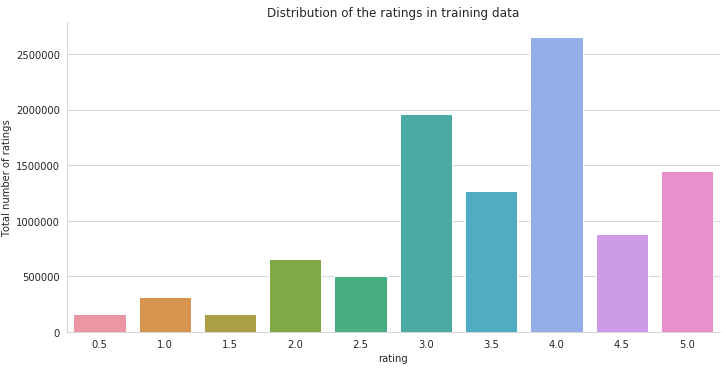

In [11]:
with sns.axes_style('whitegrid'):
    g = sns.catplot("rating", data=train, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
    plt.title('Distribution of the ratings in training data')
print (f'Average rating in dataset: {np.mean(train["rating"])}')

In [12]:
# Merge train and movies datasets on movieId
df=pd.merge(train,movies,how='left',on='movieId') # Lefft join in train to prevent data loss

In [13]:
# Merge imdb_data on df
df=pd.merge(df,imdb,how='left',on='movieId')

In [14]:
# Check df dataframe
df.head()

,userId,movieId,rating,timestamp,title,genres,title_cast,director,runtime,budget,plot_keywords
0,5163,57669,4.0,1518349992,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh,107.0,"$15,000,000",dwarf|bruges|irish|hitman
1,106343,5,4.5,1206238739,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion
2,146790,5459,5.0,1076215539,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham,88.0,"$140,000,000",lingerie|michael jackson character|shorthaired...
3,106362,32296,2.0,1423042565,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime,Sandra Bullock|Regina King|Enrique Murciano|Wi...,Marc Lawrence,115.0,"$45,000,000",female protagonist|cleave gag|good woman|fbi
4,9041,366,3.0,833375837,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller,Jeff Davis|Heather Langenkamp|Miko Hughes|Matt...,Wes Craven,112.0,"$8,000,000",freddy krueger|elm street|famous director as h...


In [15]:
# Generate a movie_rating dataframe
movie_rating=df.groupby(['title'])['rating'].mean() # agg rating by mean
movie_rating=pd.DataFrame(movie_rating)
movie_rating

,rating
title,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",3.000000
"""Great Performances"" Cats (1998)",2.753731
#1 Cheerleader Camp (2010),1.900000
#Female Pleasure (2018),4.000000
#FollowMe (2019),2.400000
...,...
به نام پدر,3.250000
…And the Fifth Horseman Is Fear (1965),3.000000
チェブラーシカ (2010),2.000000


In [16]:
# Generate column to sum number of ratings per title
movie_rating['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())

In [17]:
movie_rating.head()

,rating,num of ratings
title,,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",3.000000,1
"""Great Performances"" Cats (1998)",2.753731,67
#1 Cheerleader Camp (2010),1.900000,5
#Female Pleasure (2018),4.000000,1
#FollowMe (2019),2.400000,5


In [18]:
# Most rated titles
most_rated = pd.DataFrame(df.groupby('title')['rating'].count().sort_values(ascending=False)).reset_index()

In [19]:
most_rated

,title,rating
0,"Shawshank Redemption, The (1994)",32831
1,Forrest Gump (1994),32383
2,Pulp Fiction (1994),31697
3,"Silence of the Lambs, The (1991)",29444
4,"Matrix, The (1999)",29014
...,...,...
48146,Love on the Dole (1941),1
48147,Love's Abiding Joy (2006),1
48148,Love's Brother (2004),1
48149,Love's Coming (2014),1


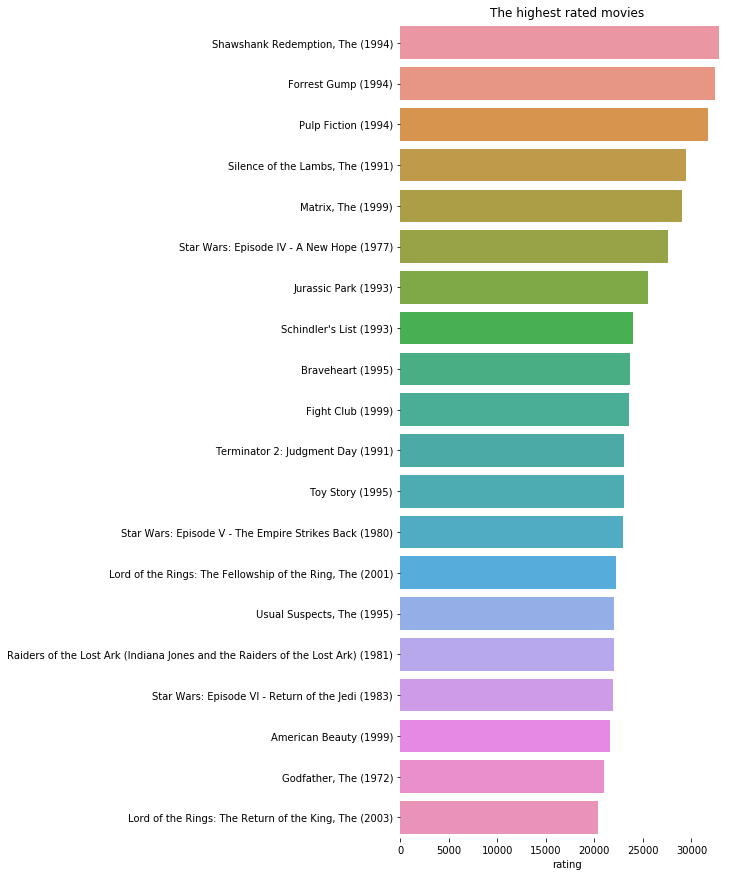

In [20]:
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(data=most_rated[0:20],y='title',x='rating')
# Add a legend and informative axis label
ax.set(ylabel="",
       xlabel="rating")
ax.title.set_text('The highest rated movies')
sns.despine(left=True, bottom=True)

In [21]:
popular_genres = pd.DataFrame(movies[['genres','title']].groupby('genres').count())

In [27]:
popular_genres.head()

,title
genres,
(no genres listed),5062
Action,562
Action|Adventure,200
Action|Adventure|Animation,30
Action|Adventure|Animation|Children,6


In [28]:
# The minimum and maximum ratings given by the users
print('The minimum rating given is:',movie_rating['rating'].min())
print('The maximum rating given is:',movie_rating['rating'].max())

The minimum rating given is: 0.5
The maximum rating given is: 5.0


In [29]:
# Function creates ranges for ratings
# To be used for visualisations

def rating_range(text):
  
  if int (text) < 1:
    return '0-1'
  elif int (text) <2:
    return'1-2'
  elif int (text) <3:
    return '2-3'
  elif int (text) <4:
    return '3-4'
  else:
    return '4-5'

In [30]:
# Apply rating_range function to generate a range column
movie_rating['range']=movie_rating['rating'].apply(rating_range)

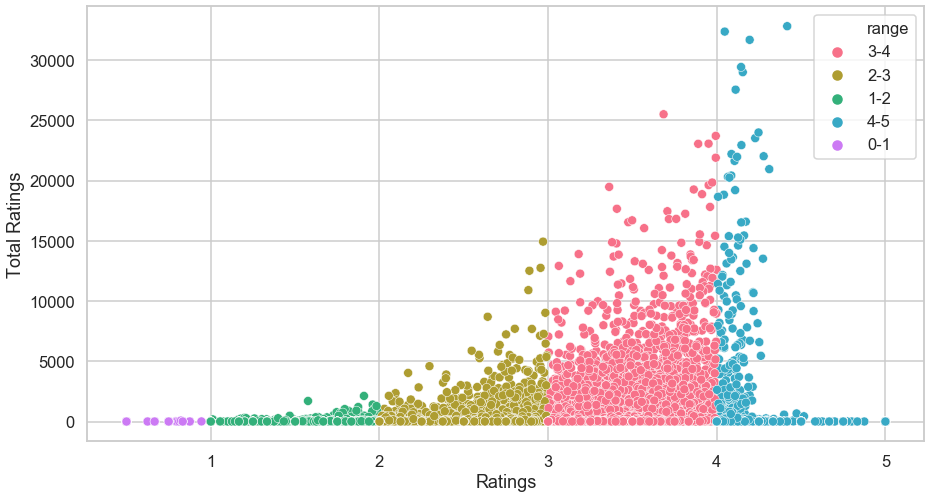

In [31]:
# Plot scatter plot illustrating the relationship between ratings and number of ratings

sns.set(style="whitegrid", context="talk")
f, ax = plt.subplots(figsize=(15, 8))
sns.scatterplot(x=movie_rating['rating'], y=movie_rating['num of ratings'],
hue=movie_rating['range'],palette="husl",sizes=(1, 8), linewidth=0.5,data=movie_rating, ax=ax) # range used to categorise ratings
plt.xlabel('Ratings') 
plt.ylabel('Total Ratings') 
plt.show()

#Modelling

A recommender system functions by predicting a user's rating or preference for an item.

There are two primary sets of entities:
- the Users ( individuals who interact with the items)
- the Items (a thing which is consumed)


Items can be:
- watched
- read
- bought
- clicked-on
- considered.


Items are passive, meaning that their properties or nature does not change.

Users create ratings for specific items within a recommendation system.

There are two approaches to recommending movies:
 - collaborative based filtering
 - content based filtering

## Collaborative based prediction
A reader is needed in order to input `rating_scale` parameter

In [32]:
reader = Reader(rating_scale=(1, 5))

 - Load data into format that Surprise understands using Dataset class from surprise
 - The columns must correspond to user id, item id and ratings (in that order).

In [33]:
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)

We can now use this dataset as we please, e.g. calling cross_validate

In [34]:
# We are using the full train dataset to train the model here - should use test and train split in order to evaluate
trainset = data.build_full_trainset()

### SVD model

In [35]:
# Build an algorithm, and train it.
algo = SVD()
algo.fit(trainset)

In [38]:
# Pickle model
model_save_path = "SVD_full_dataset.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(algo,file)

Example on how to predict using the SVD algorithm

In [39]:
# raw user id (as in the ratings file). They are **strings**!
uid = str(1)
# raw item id (as in the ratings file). They are **strings**!
iid = str(2011)

Get a prediction for specific users and items.

In [40]:
pred = algo.predict(uid, iid, r_ui=4, verbose=True)

user: 1          item: 2011       r_ui = 4.00   est = 3.53   {'was_impossible': False}


Get a prediction for the test data

In [43]:
test_df = pd.read_csv('Documents/movies/test.csv')

In [44]:
# Predict on our test data
predcol = []
for _, row in test_df.iterrows():
    x = (algo.predict(row.userId, row.movieId))
    pred = x[3]
    predcol.append(pred)

In [45]:
# check if the prediction length is the same as input length
len(predcol) == len(test_df)

True

In [46]:
# Convert columns to string in order to prep for concatenating
test_df['userId'] = test_df['userId'].astype(str)
test_df['movieId'] = test_df['movieId'].astype(str)

In [47]:
# Create submission column ID
test_df['Id'] =test_df['userId']+'_'+test_df['movieId']

In [48]:
kaggle_df = pd.DataFrame(
    {'Id': test_df['Id'],
     'rating': predcol
    })

In [49]:
kaggle_df.shape

(5000019, 2)

In [50]:
kaggle_df.head()

,Id,rating
0,1_2011,3.441536
1,1_4144,3.940187
2,1_5767,4.155973
3,1_6711,4.047568
4,1_7318,2.399892


In [51]:
# Export to csv
kaggle_df.to_csv("SVD_base.csv",index=False)

## Content based prediction
In Content-based Filtering, we seek to make recommendations based on how similar the properties or features of an item are to other items.

In [52]:
column_list=['timestamp','runtime','budget','plot_keywords']
df.drop(column_list,axis=1,inplace=True)

In [53]:
# Check df shape
row,column=df.shape
print('The dataframe has {} rows and {} columns.'.format(row, column))

The dataframe has 10000038 rows and 7 columns.


In [54]:
df.head(5)

,userId,movieId,rating,title,genres,title_cast,director
0,5163,57669,4.0,In Bruges (2008),Comedy|Crime|Drama|Thriller,Elizabeth Berrington|Rudy Blomme|Olivier Bonjo...,Martin McDonagh
1,106343,5,4.5,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett
2,146790,5459,5.0,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,Action|Comedy|Sci-Fi,Tommy Lee Jones|Will Smith|Rip Torn|Lara Flynn...,Lowell Cunningham
3,106362,32296,2.0,Miss Congeniality 2: Armed and Fabulous (2005),Adventure|Comedy|Crime,Sandra Bullock|Regina King|Enrique Murciano|Wi...,Marc Lawrence
4,9041,366,3.0,Wes Craven's New Nightmare (Nightmare on Elm S...,Drama|Horror|Mystery|Thriller,Jeff Davis|Heather Langenkamp|Miko Hughes|Matt...,Wes Craven


In [55]:
# Function takes in text as input and removes pipe
def remove_pipe(text):
  text=str (text)
  text=text.replace("|",",")
  return text

In [56]:
# Apply remove_pipe to columns title_cast and genres
df['genres']=df['genres'].fillna('') #fill missing values with blanks
df['title_cast']=df['title_cast'].fillna('') #fill missing values with blanks

df['title_cast']=df['title_cast'].apply(remove_pipe) #apply remove_pipe sunction
df['genres']=df['genres'].apply(remove_pipe)
df.head()

,userId,movieId,rating,title,genres,title_cast,director
0,5163,57669,4.0,In Bruges (2008),"Comedy,Crime,Drama,Thriller","Elizabeth Berrington,Rudy Blomme,Olivier Bonjo...",Martin McDonagh
1,106343,5,4.5,Father of the Bride Part II (1995),Comedy,"Steve Martin,Diane Keaton,Martin Short,Kimberl...",Albert Hackett
2,146790,5459,5.0,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (...,"Action,Comedy,Sci-Fi","Tommy Lee Jones,Will Smith,Rip Torn,Lara Flynn...",Lowell Cunningham
3,106362,32296,2.0,Miss Congeniality 2: Armed and Fabulous (2005),"Adventure,Comedy,Crime","Sandra Bullock,Regina King,Enrique Murciano,Wi...",Marc Lawrence
4,9041,366,3.0,Wes Craven's New Nightmare (Nightmare on Elm S...,"Drama,Horror,Mystery,Thriller","Jeff Davis,Heather Langenkamp,Miko Hughes,Matt...",Wes Craven


Taking the df dataframe. A filtered dataframe with unique movie titles can be generated to remove duplicate movie titles due to multiple user ratings.

In [57]:
# A content column can be generated from the title_cast and genres columns
# This column will be used to build the content recommender

df['content']=df['title_cast']+' '+ df['genres']
df['content'][0]

'Elizabeth Berrington,Rudy Blomme,Olivier Bonjour,Mark Donovan,Ann Elsley,Colin Farrell,Jean-Marc Favorin,Ralph Fiennes,Brendan Gleeson,Eric Godon,Zeljko Ivanek,Sachi Kimura,Anna Madeley,Louis Nummy,Clémence Poésy Comedy,Crime,Drama,Thriller'

In [58]:
# A ratings dataframe can be generated from uniw\que movie titles and their average ratings across all users
ratings=df.groupby(['title'])['rating'].mean() #group by title and aggregate ratings
ratings=pd.DataFrame(ratings)
ratings=ratings.fillna(2) # fill missing values with generic score of 2 (40%)
ratings['num of ratings']=df.groupby(['title'])['rating'].count() #generate a column witht the total number of ratings
ratings.head(5)

,rating,num of ratings
title,,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",3.000000,1
"""Great Performances"" Cats (1998)",2.753731,67
#1 Cheerleader Camp (2010),1.900000,5
#Female Pleasure (2018),4.000000,1
#FollowMe (2019),2.400000,5


In [59]:
content=df.groupby(['title'])['content'].unique() #group by title and display unique values in a list
content=pd.DataFrame(content)
content.head(5)

,content
title,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)","[ Documentary,Drama]"
"""Great Performances"" Cats (1998)","[Elaine Paige,John Mills,Ken Page,Rosemarie Fo..."
#1 Cheerleader Camp (2010),"[ Comedy,Drama]"
#Female Pleasure (2018),[ Documentary]
#FollowMe (2019),"[ Horror,Thriller]"


In [60]:
# Generate single dataframe
movie_df=pd.merge(ratings,content,on='title') #join on index
row,column=movie_df.shape
print('The dataframe has {} rows (representing unique movie titles) and {} columns.'.format(row, column))
movie_df.head(5)

The dataframe has 48151 rows (representing unique movie titles) and 3 columns.


,rating,num of ratings,content
title,,,
"""BLOW THE NIGHT!"" Let's Spend the Night Together (1983)",3.000000,1,"[ Documentary,Drama]"
"""Great Performances"" Cats (1998)",2.753731,67,"[Elaine Paige,John Mills,Ken Page,Rosemarie Fo..."
#1 Cheerleader Camp (2010),1.900000,5,"[ Comedy,Drama]"
#Female Pleasure (2018),4.000000,1,[ Documentary]
#FollowMe (2019),2.400000,5,"[ Horror,Thriller]"


In [61]:
# Sort move_df from highest to lowest num of ratings
movie_df=movie_df.sort_values('num of ratings',ascending=False)
movie_df.head(5)

,rating,num of ratings,content
title,,,
"Shawshank Redemption, The (1994)",4.417624,32831,"[Tim Robbins,Morgan Freeman,Bob Gunton,William..."
Forrest Gump (1994),4.047216,32383,"[Tom Hanks,Rebecca Williams,Sally Field,Michae..."
Pulp Fiction (1994),4.195097,31697,"[Tim Roth,Amanda Plummer,Laura Lovelace,John T..."
"Silence of the Lambs, The (1991)",4.144172,29444,"[Jodie Foster,Lawrence A. Bonney,Kasi Lemmons,..."
"Matrix, The (1999)",4.154253,29014,"[Keanu Reeves,Laurence Fishburne,Carrie-Anne M..."


In [62]:
# Function will remove items from lists into strings
def string(input):
  string=' '
  for i in input:
    string=string+str (i)
  return string

In [63]:
# Generate strings from lists
movie_df['content']=movie_df['content'].apply(string) #generate strings
movie_df['content'][1]

' Tom Hanks,Rebecca Williams,Sally Field,Michael Conner Humphreys,Harold G. Herthum,George Kelly,Bob Penny,John Randall,Sam Anderson,Margo Moorer,Ione M. Telech,Christine Seabrook,John Worsham,Peter Dobson,Siobhan Fallon Hogan Comedy,Drama,Romance,War'

The movie_df dataframe is the base from which the recommender is built. 

The content column will be the feature used, which will be vectorized and converted to a similarity matrix mxm

In [64]:
# A subset of the movies will be used. The greater the subset, the more memory is committed
# The cosine similiarity size is proportional to feature size
#First 200000 movies are selected
feature=movie_df['content'][0:20000]

In [65]:
# Set up vectorizer
vec=TfidfVectorizer(stop_words='english') # term frequency inverse document frequency

In [66]:
# Vectorize combined column
feature_vec=vec.fit_transform(feature)
shape,column=feature_vec.shape
print('feature_vec is a sparse matrix with {} rows (representing unique movie titles) and {} columns.'.format(row, column))

feature_vec is a sparse matrix with 48151 rows (representing unique movie titles) and 51897 columns.



The cosine similarity will be used to determine how similar two entities are based off the angle between their two vectors formed. The closer a value is to 1, to higher the similarity

The cosine similarity is formed from the dot product of the feature_vec matrix and its transpose divided by the product of their magniudes.

In [67]:
# Use cosine similarity to get similarity matrix
sim_matrix =cosine_similarity(feature_vec,feature_vec)
row,column=sim_matrix.shape
print('The sim_mat matrix has {} rows and {} columns.'.format(row, column))

The sim_mat matrix has 20000 rows and 20000 columns.


In [ ]:
# Double check
# Reset the move_df index as it will be used to generate a Series that will map sim_mat
movie_df=movie_df.reset_index()
movie_df.head(5)del imdb
del movies

In [ ]:
# Index mapping
index_map = pd.Series(movie_df.index,index = movie_df['title']) # contains a series of the movie titles in movie_df
index_map

In [ ]:
# Function takes in a movie title as an input and returns 10 movie title recommendations

def recommendation(title):
  index = index_map[title] # returns the index of the argument title in index_map
  similarity = list(enumerate(sim_matrix[index])) # returns a list of with index and similarity
  similarity = sorted(similarity, key=lambda x: x[1], reverse=True) # sorts list in descending order
  similarity = similarity[1:11] # top 10 recommendations
  #return movie names using the mapping series
  movie_indices = [i[0] for i in similarity] # obtain indices for recommended movies
  return (movie_df['title'].iloc[movie_indices]) # filter movie_df for titles

Using the animated movie Aladin from 1992. The recommender returns viewing options consisting of animated movies such as Moana, Minions and Dragons: Dawn Of The Dragon Racers.



In [ ]:
# Lets search for recommendations based off Aladdin
recommendations=recommendation('Aladdin (1992)')
recommend_list=list(recommendations)
recommend_list

In [ ]:
# pickle recommendation function
model_save_path = "content_based.pkl"
with open(model_save_path,'wb') as file:
  pickle.dump(recommendation,file)

In [ ]:
#test content-based predictor
print("testing content based recommender")
model_load_path = "content_based.pkl"
with open(model_load_path,'rb') as file:
  content_based_predict = pickle.load(file)
  print(content_based_predict('Aladdin (1992)'))   

# Comet version control

In [ ]:
# Comet logging

params = {"random_state": 'none',
          "model_type": "SVD",
          "scaler": "none",
          "param_grid": str(param_grid)
          }
metrics = {"RMSE": 'none',
           "top n": 'none',
           "MAE": 'none'
           }

# Log parameters and results
experiment.log_parameters(params)
experiment.log_metrics(metrics)

# End Experiment# Create dictionaries for comet

params = {"random_state": 'none',
          "model_type": "SVD",
          "scaler": "none",
          "param_grid": str(param_grid)
          }
metrics = {"RMSE": 'none',
           "top n": 'none',
           "MAE": 'none'
           }

# Log parameters and results
experiment.log_parameters(params)
experiment.log_metrics(metrics)

# End Experiment